### 초기 경로 설정 (클래스 이용을 위함)

In [9]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [10]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [11]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [13]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [14]:
train_images = glob.glob('/data/segmentation/wound/trainset/images/*')
train_labels = glob.glob('/data/segmentation/wound/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/wound/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/wound/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 553 elements
My custom valing-dataset has 278 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

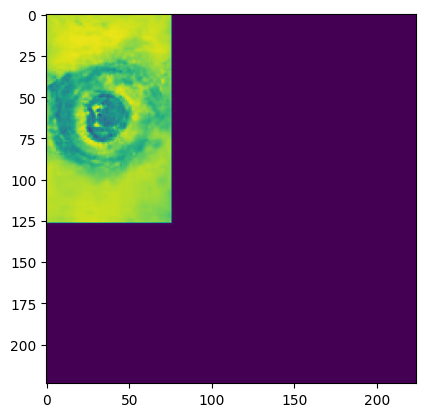

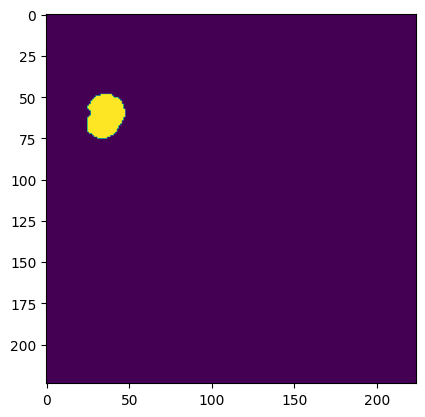

3픽셀의 평균값이라 색깔이 변경됨.


In [15]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [16]:
# Begin training
from models.SegNet.models.segnet import SegResNet
model = SegResNet(num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [17]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [18]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'SegNet'
data_name = 'wound'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 70 of 70, Train Loss: 1.507929, IoU: 0.079492, Dice: 0.138642
 Epoch: 1 of 100, Iter.: 70 of 70, Valid Loss: 1.308254, IoU: 0.131909, Dice: 0.222878

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


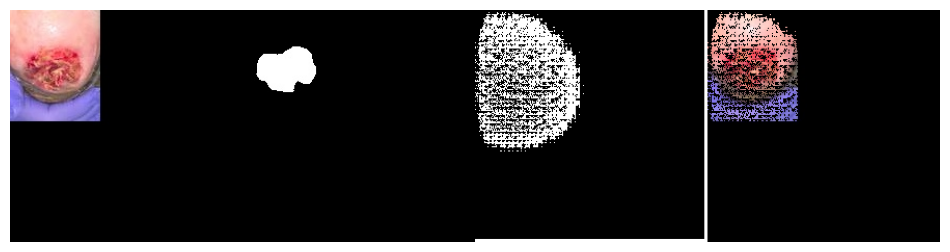

 Epoch: 2 of 100, Iter.: 70 of 70, Train Loss: 1.100617, IoU: 0.219681, Dice: 0.333649
 Epoch: 2 of 100, Iter.: 70 of 70, Valid Loss: 0.908705, IoU: 0.262596, Dice: 0.388701


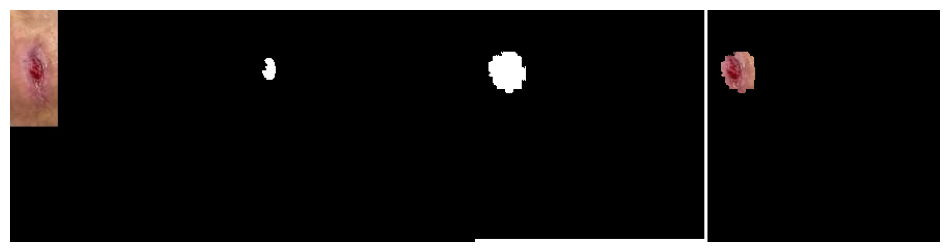

 Epoch: 3 of 100, Iter.: 70 of 70, Train Loss: 0.787130, IoU: 0.262042, Dice: 0.387514
 Epoch: 3 of 100, Iter.: 70 of 70, Valid Loss: 0.672303, IoU: 0.251708, Dice: 0.372894


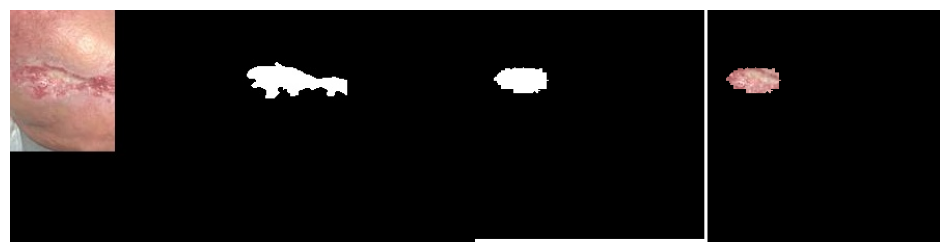

 Epoch: 4 of 100, Iter.: 70 of 70, Train Loss: 0.603904, IoU: 0.268845, Dice: 0.392849
 Epoch: 4 of 100, Iter.: 70 of 70, Valid Loss: 0.559268, IoU: 0.272939, Dice: 0.399711


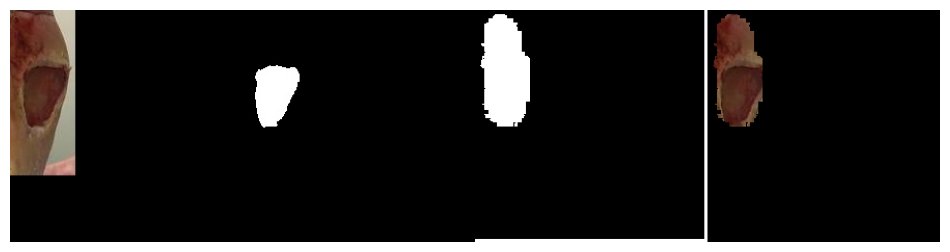

 Epoch: 5 of 100, Iter.: 70 of 70, Train Loss: 0.509268, IoU: 0.290560, Dice: 0.417809
 Epoch: 5 of 100, Iter.: 70 of 70, Valid Loss: 0.488872, IoU: 0.302005, Dice: 0.431638


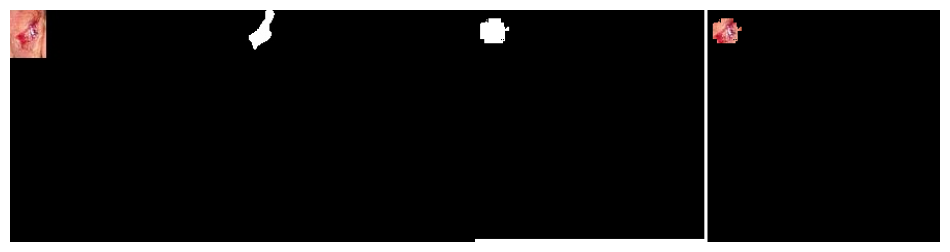

 Epoch: 6 of 100, Iter.: 70 of 70, Train Loss: 0.468233, IoU: 0.300966, Dice: 0.427656
 Epoch: 6 of 100, Iter.: 70 of 70, Valid Loss: 0.470424, IoU: 0.284687, Dice: 0.405045


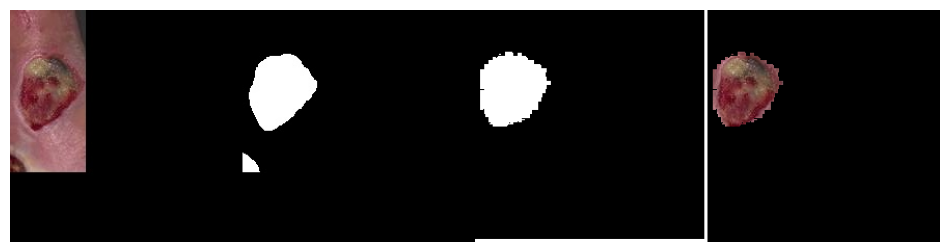

 Epoch: 7 of 100, Iter.: 70 of 70, Train Loss: 0.436517, IoU: 0.309353, Dice: 0.438225
 Epoch: 7 of 100, Iter.: 70 of 70, Valid Loss: 0.446678, IoU: 0.298816, Dice: 0.425517


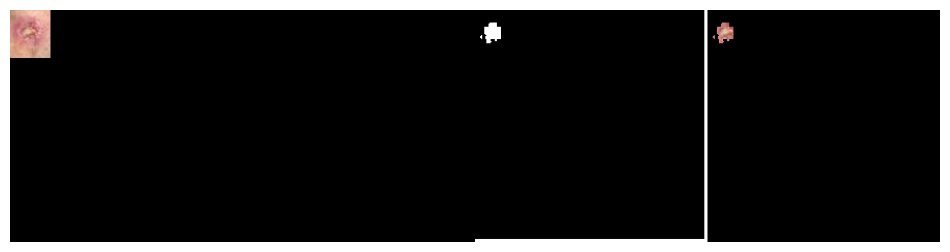

 Epoch: 8 of 100, Iter.: 70 of 70, Train Loss: 0.407890, IoU: 0.319807, Dice: 0.448844
 Epoch: 8 of 100, Iter.: 70 of 70, Valid Loss: 0.457730, IoU: 0.284466, Dice: 0.405145


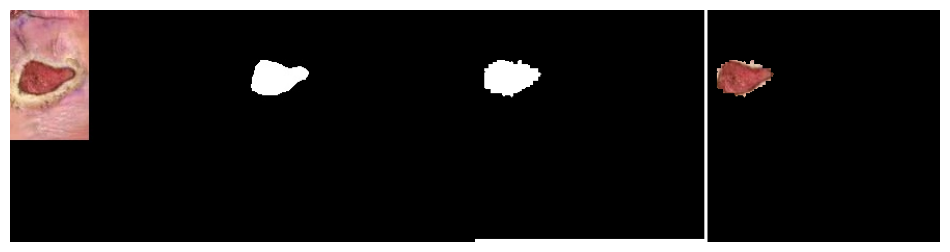

 Epoch: 9 of 100, Iter.: 70 of 70, Train Loss: 0.398485, IoU: 0.320933, Dice: 0.449875
 Epoch: 9 of 100, Iter.: 70 of 70, Valid Loss: 0.440591, IoU: 0.293280, Dice: 0.413266


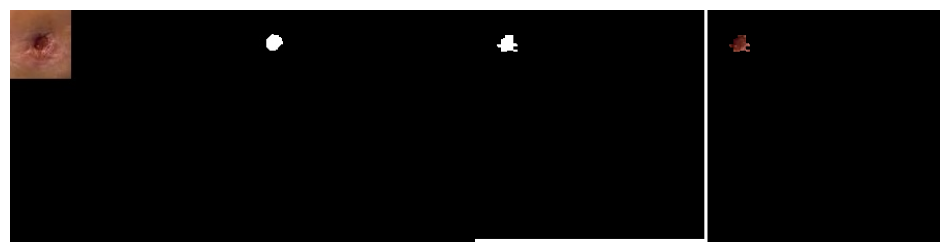

 Epoch: 10 of 100, Iter.: 70 of 70, Train Loss: 0.374832, IoU: 0.586104, Dice: 0.714315
 Epoch: 10 of 100, Iter.: 70 of 70, Valid Loss: 0.403307, IoU: 0.642551, Dice: 0.769813


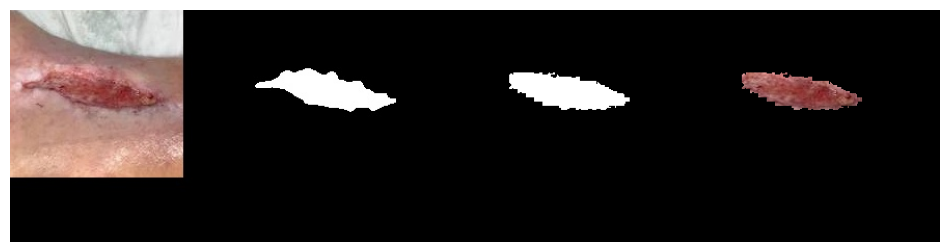

 Epoch: 11 of 100, Iter.: 70 of 70, Train Loss: 0.360862, IoU: 0.713846, Dice: 0.855859
 Epoch: 11 of 100, Iter.: 70 of 70, Valid Loss: 0.403364, IoU: 0.633173, Dice: 0.751317


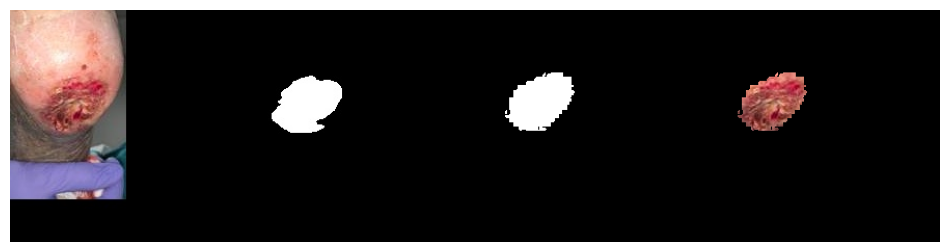

 Epoch: 12 of 100, Iter.: 70 of 70, Train Loss: 0.345514, IoU: 0.723278, Dice: 0.857080
 Epoch: 12 of 100, Iter.: 70 of 70, Valid Loss: 0.435175, IoU: 0.612682, Dice: 0.745104


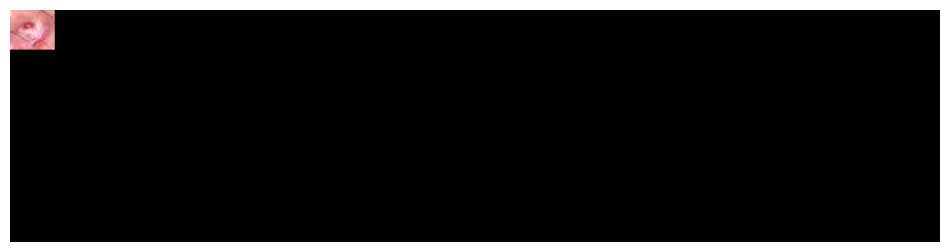

 Epoch: 13 of 100, Iter.: 70 of 70, Train Loss: 0.349515, IoU: 0.728246, Dice: 0.870449
 Epoch: 13 of 100, Iter.: 70 of 70, Valid Loss: 0.395424, IoU: 0.640881, Dice: 0.754149


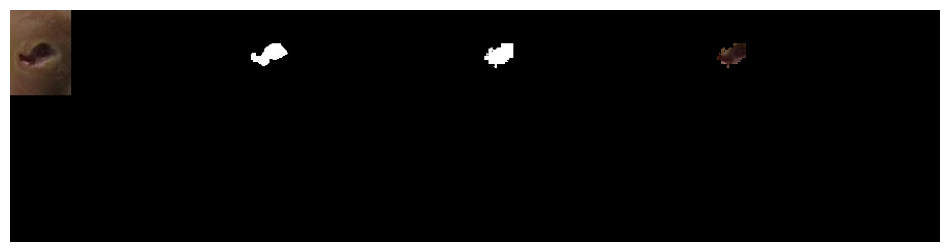

 Epoch: 14 of 100, Iter.: 70 of 70, Train Loss: 0.339335, IoU: 0.757339, Dice: 0.897009
 Epoch: 14 of 100, Iter.: 70 of 70, Valid Loss: 0.385555, IoU: 0.655331, Dice: 0.775020


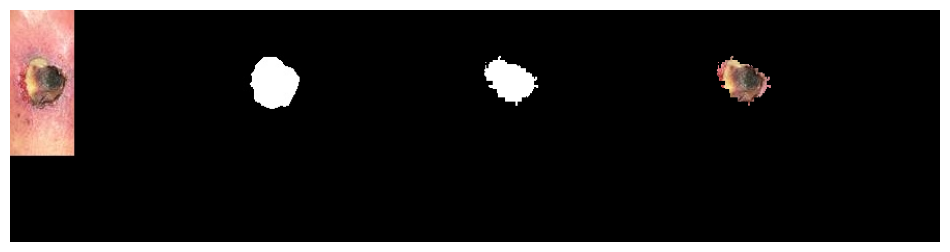

 Epoch: 15 of 100, Iter.: 70 of 70, Train Loss: 0.324883, IoU: 0.768257, Dice: 0.901065
 Epoch: 15 of 100, Iter.: 70 of 70, Valid Loss: 0.374924, IoU: 0.665925, Dice: 0.778163


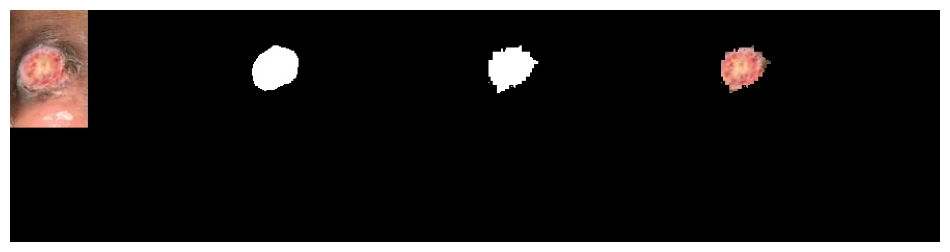

 Epoch: 16 of 100, Iter.: 70 of 70, Train Loss: 0.321005, IoU: 0.774492, Dice: 0.912580
 Epoch: 16 of 100, Iter.: 70 of 70, Valid Loss: 0.378804, IoU: 0.685815, Dice: 0.801647


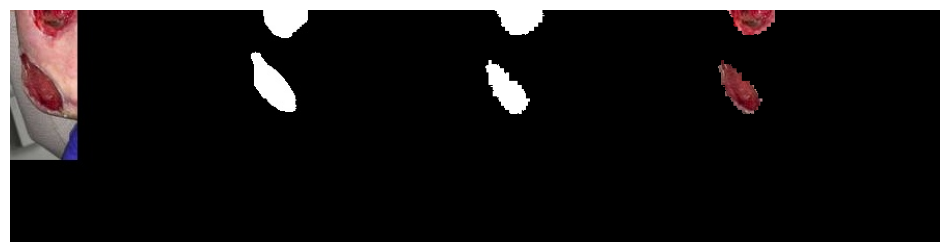

 Epoch: 17 of 100, Iter.: 70 of 70, Train Loss: 0.323368, IoU: 0.761142, Dice: 0.892283
 Epoch: 17 of 100, Iter.: 70 of 70, Valid Loss: 0.385976, IoU: 0.656091, Dice: 0.765636


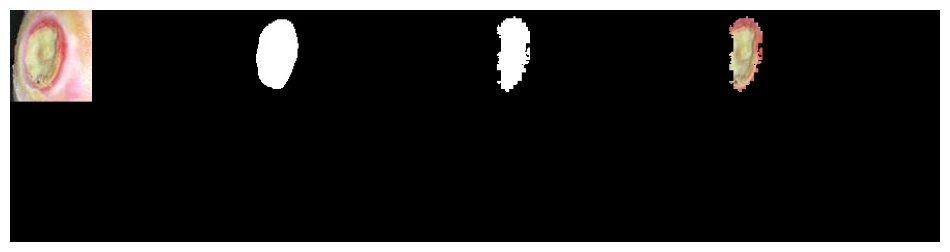

 Epoch: 18 of 100, Iter.: 70 of 70, Train Loss: 0.321606, IoU: 0.767139, Dice: 0.896195
 Epoch: 18 of 100, Iter.: 70 of 70, Valid Loss: 0.383397, IoU: 0.668425, Dice: 0.786552


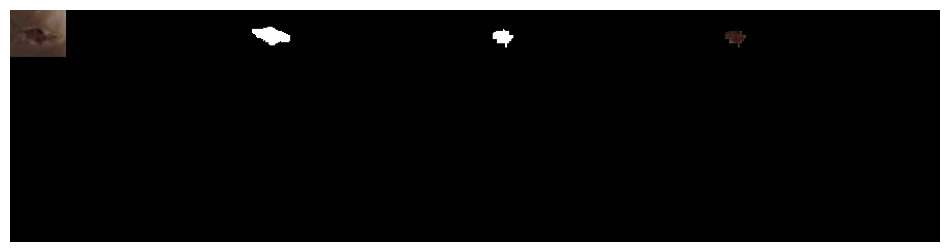

 Epoch: 19 of 100, Iter.: 70 of 70, Train Loss: 0.319657, IoU: 0.784109, Dice: 0.920855
 Epoch: 19 of 100, Iter.: 70 of 70, Valid Loss: 0.362416, IoU: 0.687568, Dice: 0.800502


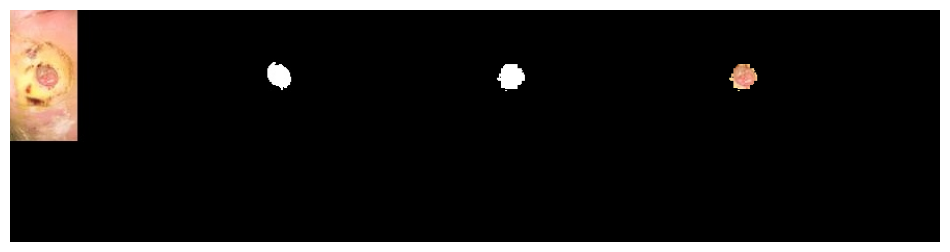

 Epoch: 20 of 100, Iter.: 70 of 70, Train Loss: 0.318405, IoU: 0.788552, Dice: 0.917884
 Epoch: 20 of 100, Iter.: 70 of 70, Valid Loss: 0.369946, IoU: 0.680889, Dice: 0.797710


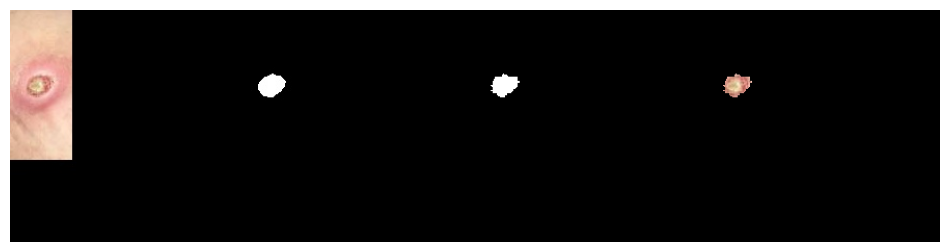

 Epoch: 21 of 100, Iter.: 70 of 70, Train Loss: 0.322453, IoU: 0.800229, Dice: 0.935318
 Epoch: 21 of 100, Iter.: 70 of 70, Valid Loss: 0.354840, IoU: 0.704216, Dice: 0.809269


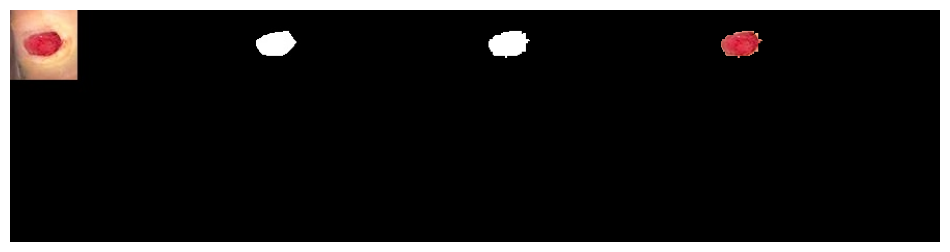

 Epoch: 22 of 100, Iter.: 70 of 70, Train Loss: 0.299909, IoU: 0.814623, Dice: 0.944735
 Epoch: 22 of 100, Iter.: 70 of 70, Valid Loss: 0.358901, IoU: 0.701178, Dice: 0.812673


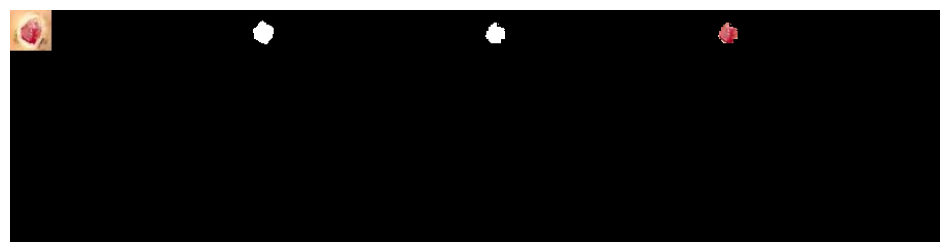

 Epoch: 23 of 100, Iter.: 70 of 70, Train Loss: 0.296743, IoU: 0.807833, Dice: 0.936214
 Epoch: 23 of 100, Iter.: 70 of 70, Valid Loss: 0.396572, IoU: 0.649753, Dice: 0.765145


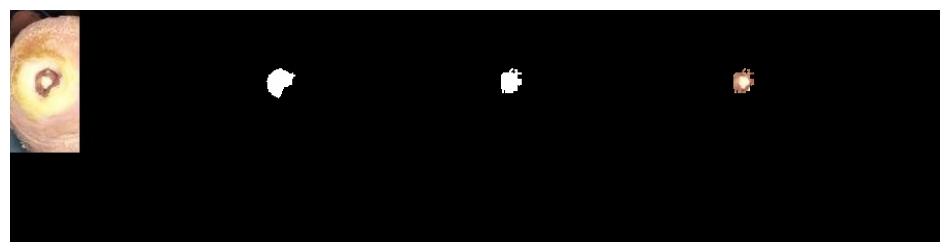

 Epoch: 24 of 100, Iter.: 70 of 70, Train Loss: 0.295470, IoU: 0.813567, Dice: 0.947430
 Epoch: 24 of 100, Iter.: 70 of 70, Valid Loss: 0.364240, IoU: 0.678915, Dice: 0.786013


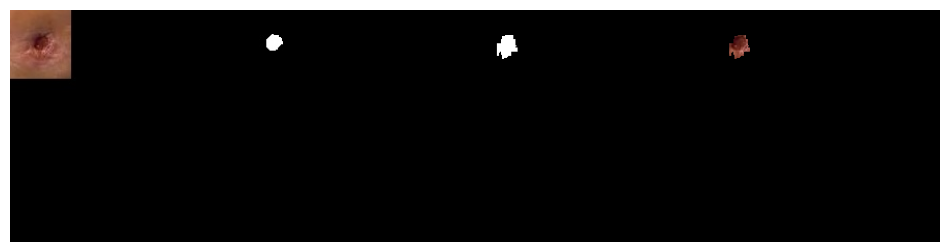

 Epoch: 25 of 100, Iter.: 70 of 70, Train Loss: 0.293182, IoU: 0.823540, Dice: 0.956714
 Epoch: 25 of 100, Iter.: 70 of 70, Valid Loss: 0.351943, IoU: 0.696255, Dice: 0.798577


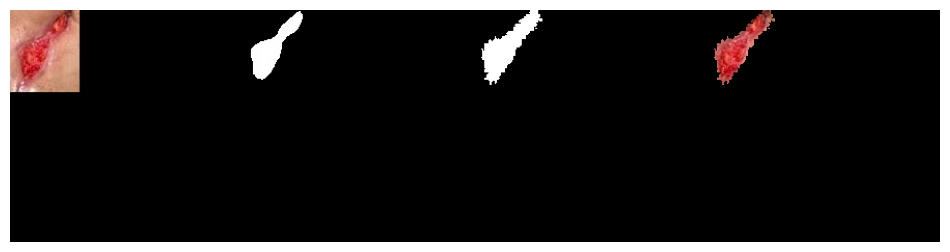

 Epoch: 26 of 100, Iter.: 70 of 70, Train Loss: 0.298458, IoU: 0.814286, Dice: 0.939547
 Epoch: 26 of 100, Iter.: 70 of 70, Valid Loss: 0.361613, IoU: 0.696486, Dice: 0.810537


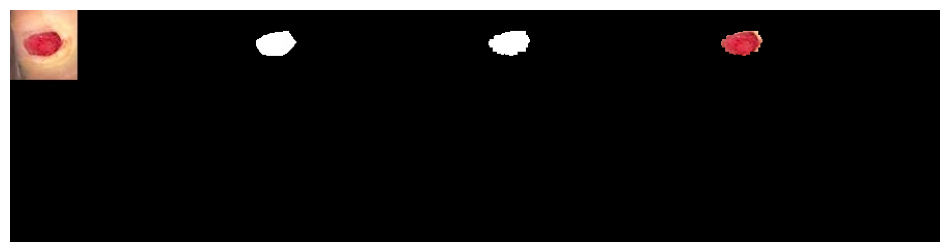

 Epoch: 27 of 100, Iter.: 70 of 70, Train Loss: 0.304500, IoU: 0.804321, Dice: 0.925700
 Epoch: 27 of 100, Iter.: 70 of 70, Valid Loss: 0.360624, IoU: 0.684023, Dice: 0.790936


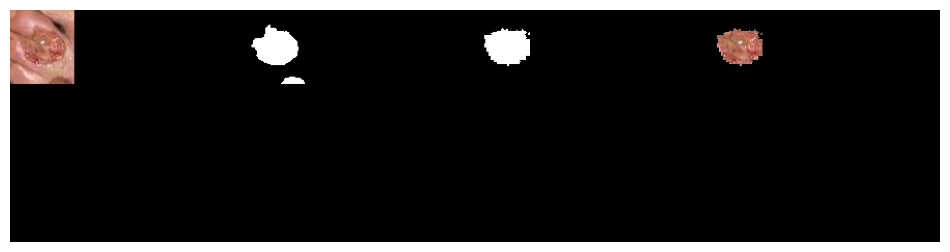

 Epoch: 28 of 100, Iter.: 70 of 70, Train Loss: 0.299462, IoU: 0.817789, Dice: 0.945281
 Epoch: 28 of 100, Iter.: 70 of 70, Valid Loss: 0.349266, IoU: 0.698197, Dice: 0.797783


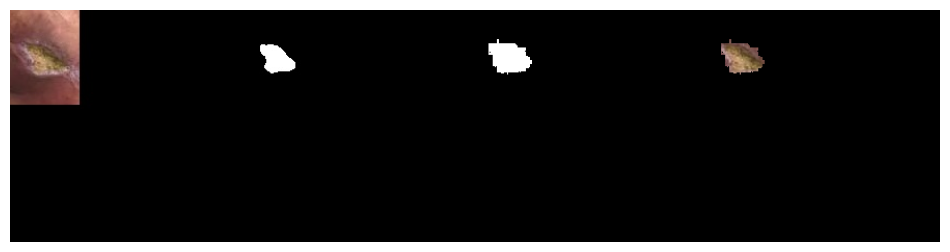

 Epoch: 29 of 100, Iter.: 70 of 70, Train Loss: 0.293211, IoU: 0.828632, Dice: 0.951223
 Epoch: 29 of 100, Iter.: 70 of 70, Valid Loss: 0.353302, IoU: 0.699990, Dice: 0.812820


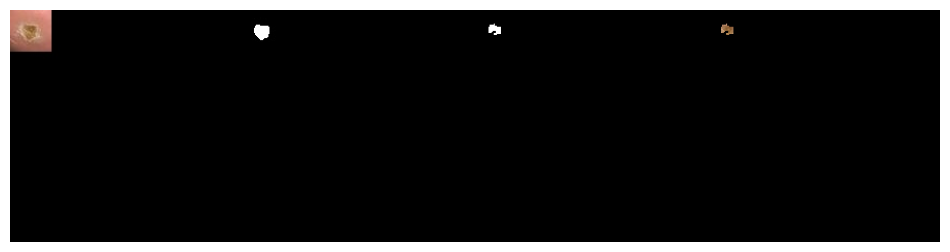

 Epoch: 30 of 100, Iter.: 70 of 70, Train Loss: 0.288342, IoU: 0.830199, Dice: 0.953678
 Epoch: 30 of 100, Iter.: 70 of 70, Valid Loss: 0.349767, IoU: 0.713072, Dice: 0.830165


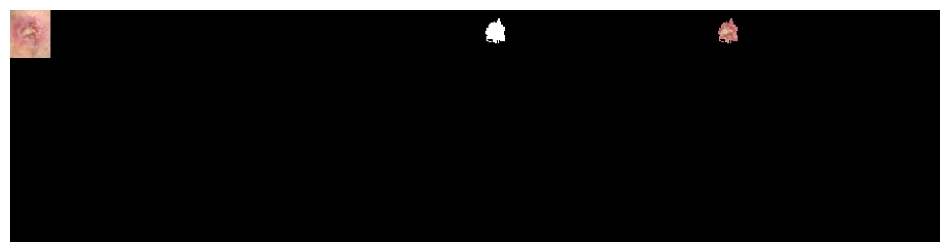

 Epoch: 31 of 100, Iter.: 70 of 70, Train Loss: 0.282502, IoU: 0.831748, Dice: 0.961675
 Epoch: 31 of 100, Iter.: 70 of 70, Valid Loss: 0.370061, IoU: 0.690262, Dice: 0.805005


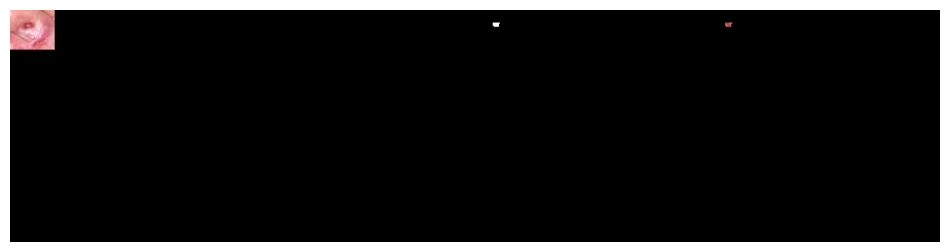

 Epoch: 32 of 100, Iter.: 70 of 70, Train Loss: 0.287284, IoU: 0.829441, Dice: 0.957793
 Epoch: 32 of 100, Iter.: 70 of 70, Valid Loss: 0.354007, IoU: 0.687522, Dice: 0.800025


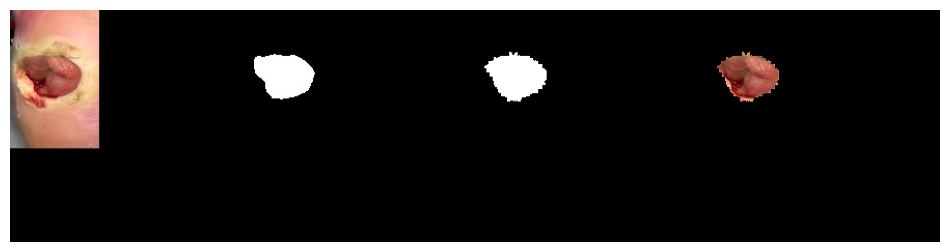

 Epoch: 33 of 100, Iter.: 70 of 70, Train Loss: 0.282768, IoU: 0.836864, Dice: 0.965936
 Epoch: 33 of 100, Iter.: 70 of 70, Valid Loss: 0.358682, IoU: 0.701604, Dice: 0.816613


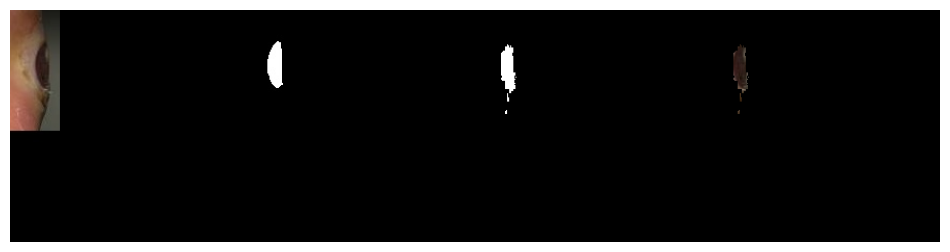

 Epoch: 34 of 100, Iter.: 70 of 70, Train Loss: 0.277703, IoU: 0.843029, Dice: 0.967268
 Epoch: 34 of 100, Iter.: 70 of 70, Valid Loss: 0.352115, IoU: 0.706820, Dice: 0.816423


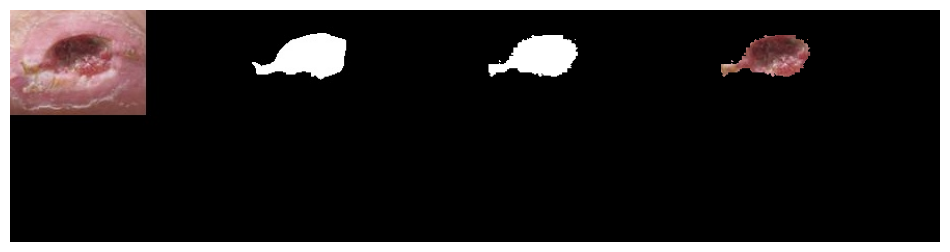

 Epoch: 35 of 100, Iter.: 70 of 70, Train Loss: 0.272955, IoU: 0.849688, Dice: 0.973743
 Epoch: 35 of 100, Iter.: 70 of 70, Valid Loss: 0.352806, IoU: 0.701047, Dice: 0.811142


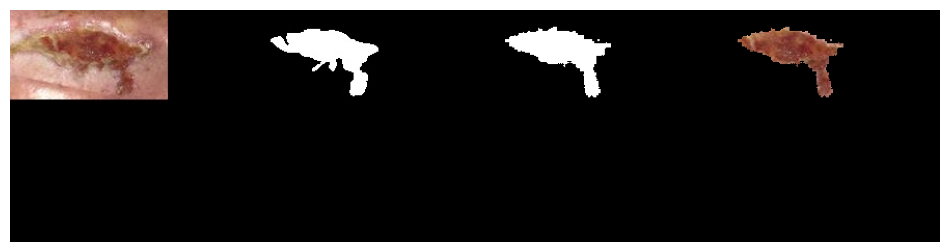

 Epoch: 36 of 100, Iter.: 70 of 70, Train Loss: 0.273766, IoU: 0.848948, Dice: 0.973631
 Epoch: 36 of 100, Iter.: 70 of 70, Valid Loss: 0.345756, IoU: 0.714544, Dice: 0.819670


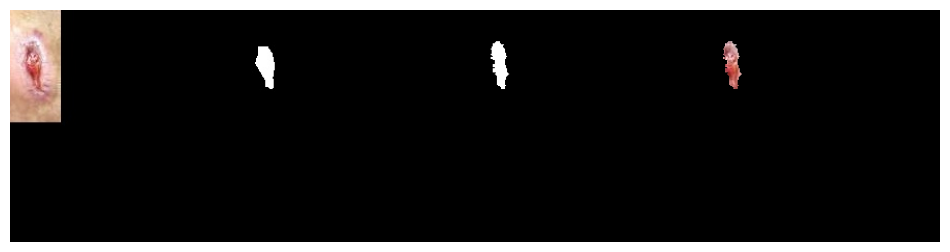

 Epoch: 37 of 100, Iter.: 70 of 70, Train Loss: 0.285483, IoU: 0.836222, Dice: 0.957986
 Epoch: 37 of 100, Iter.: 70 of 70, Valid Loss: 0.361141, IoU: 0.705397, Dice: 0.816799


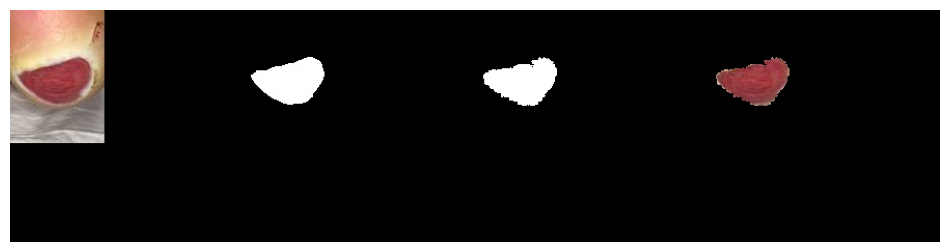

 Epoch: 38 of 100, Iter.: 70 of 70, Train Loss: 0.282128, IoU: 0.834853, Dice: 0.954056
 Epoch: 38 of 100, Iter.: 70 of 70, Valid Loss: 0.360209, IoU: 0.700231, Dice: 0.817148


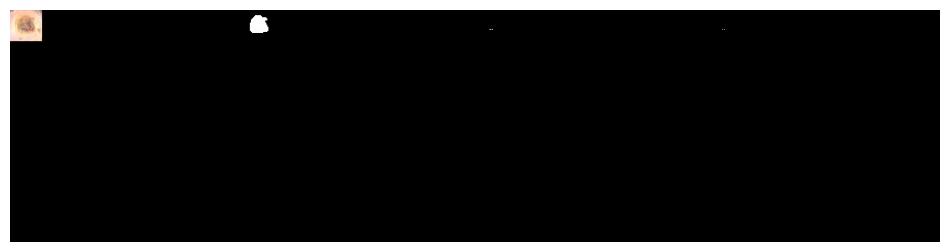

 Epoch: 39 of 100, Iter.: 70 of 70, Train Loss: 0.279323, IoU: 0.843158, Dice: 0.969266
 Epoch: 39 of 100, Iter.: 70 of 70, Valid Loss: 0.351406, IoU: 0.708433, Dice: 0.818697


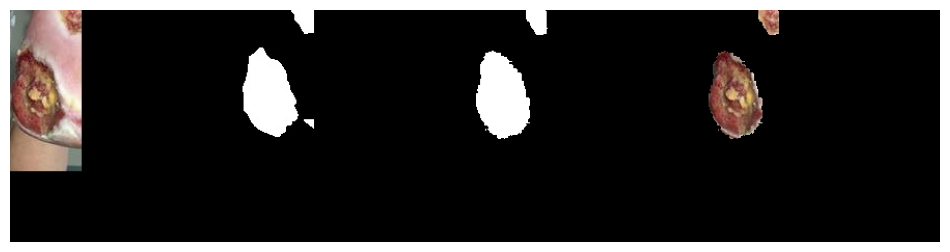

 Epoch: 40 of 100, Iter.: 70 of 70, Train Loss: 0.276753, IoU: 0.837839, Dice: 0.965463
 Epoch: 40 of 100, Iter.: 70 of 70, Valid Loss: 0.347876, IoU: 0.707637, Dice: 0.816493


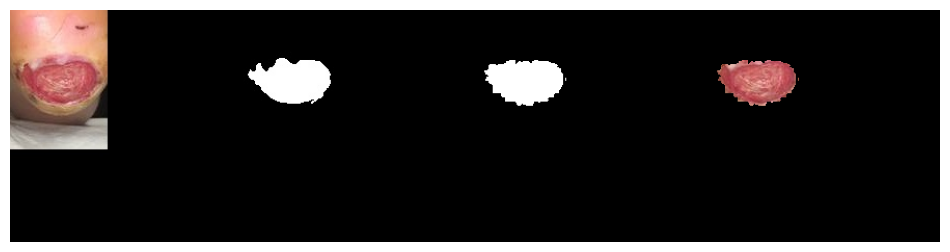

 Epoch: 41 of 100, Iter.: 70 of 70, Train Loss: 0.274932, IoU: 0.844948, Dice: 0.968849
 Epoch: 41 of 100, Iter.: 70 of 70, Valid Loss: 0.349551, IoU: 0.706873, Dice: 0.819291


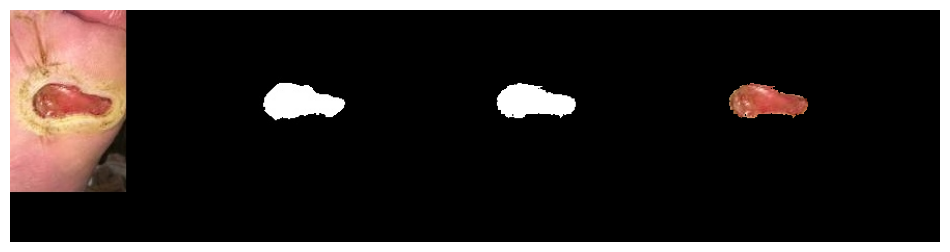

 Epoch: 42 of 100, Iter.: 70 of 70, Train Loss: 0.270515, IoU: 0.849140, Dice: 0.968531
 Epoch: 42 of 100, Iter.: 70 of 70, Valid Loss: 0.340588, IoU: 0.713278, Dice: 0.818049


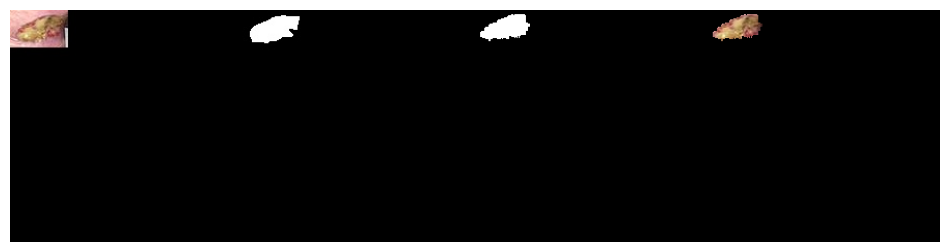

 Epoch: 43 of 100, Iter.: 70 of 70, Train Loss: 0.264691, IoU: 0.858932, Dice: 0.982314
 Epoch: 43 of 100, Iter.: 70 of 70, Valid Loss: 0.340309, IoU: 0.718526, Dice: 0.828589


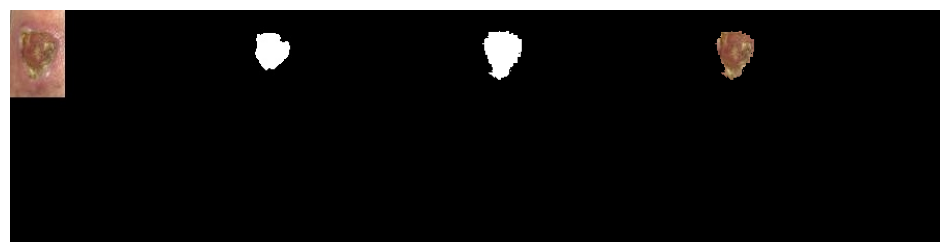

 Epoch: 44 of 100, Iter.: 70 of 70, Train Loss: 0.265178, IoU: 0.862393, Dice: 0.984334
 Epoch: 44 of 100, Iter.: 70 of 70, Valid Loss: 0.348447, IoU: 0.707604, Dice: 0.810197


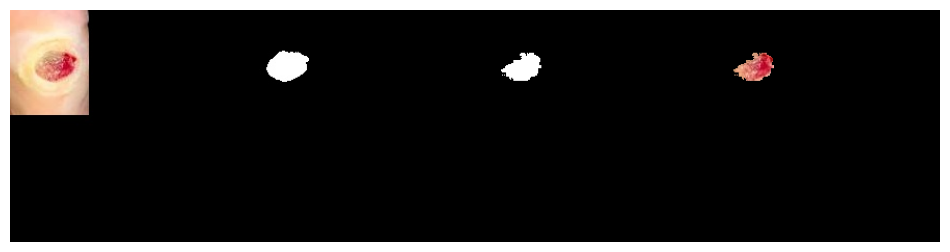

 Epoch: 45 of 100, Iter.: 70 of 70, Train Loss: 0.272717, IoU: 0.850901, Dice: 0.972198
 Epoch: 45 of 100, Iter.: 70 of 70, Valid Loss: 0.347167, IoU: 0.705507, Dice: 0.820367


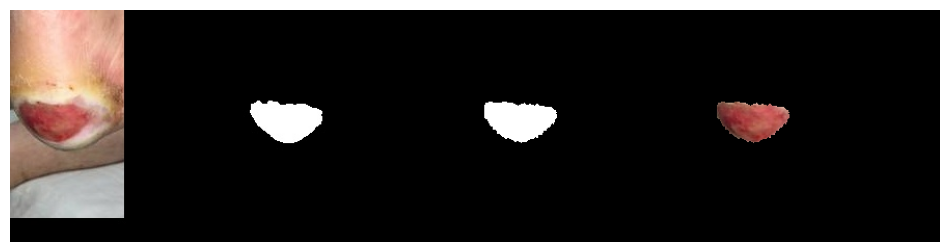

 Epoch: 46 of 100, Iter.: 70 of 70, Train Loss: 0.266706, IoU: 0.860040, Dice: 0.982619
 Epoch: 46 of 100, Iter.: 70 of 70, Valid Loss: 0.350325, IoU: 0.715068, Dice: 0.826250


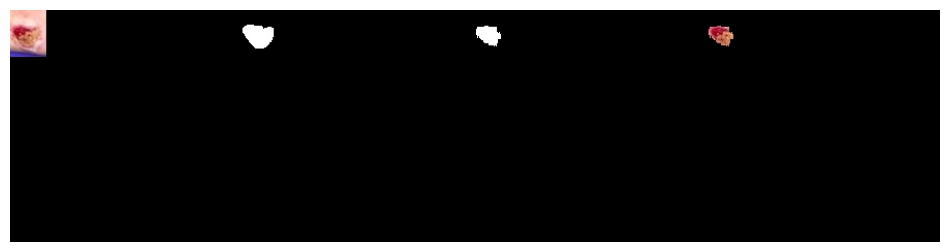

 Epoch: 47 of 100, Iter.: 70 of 70, Train Loss: 0.271007, IoU: 0.851464, Dice: 0.967476
 Epoch: 47 of 100, Iter.: 70 of 70, Valid Loss: 0.357685, IoU: 0.689942, Dice: 0.802068


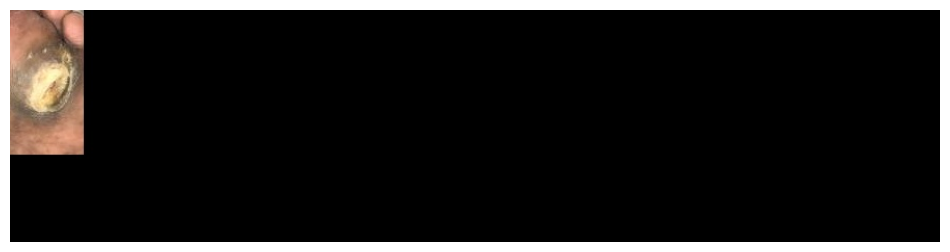

 Epoch: 48 of 100, Iter.: 70 of 70, Train Loss: 0.262009, IoU: 0.864964, Dice: 0.986185
 Epoch: 48 of 100, Iter.: 70 of 70, Valid Loss: 0.337110, IoU: 0.724222, Dice: 0.835765


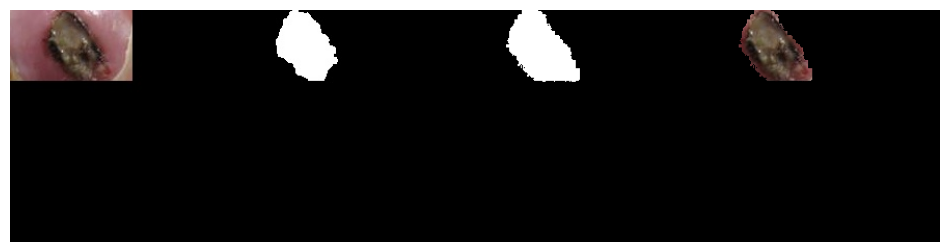

 Epoch: 49 of 100, Iter.: 70 of 70, Train Loss: 0.273887, IoU: 0.848395, Dice: 0.965763
 Epoch: 49 of 100, Iter.: 70 of 70, Valid Loss: 0.334135, IoU: 0.720001, Dice: 0.831062


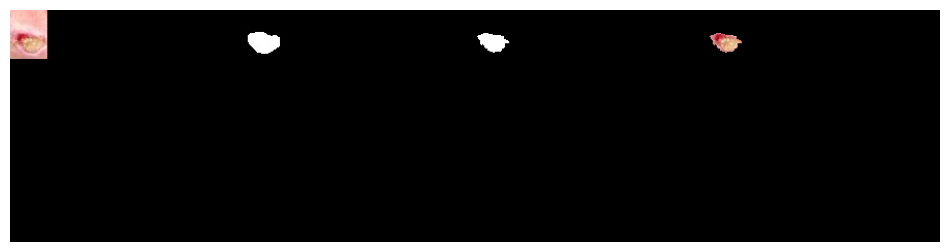

 Epoch: 50 of 100, Iter.: 70 of 70, Train Loss: 0.287162, IoU: 0.823746, Dice: 0.938078
 Epoch: 50 of 100, Iter.: 70 of 70, Valid Loss: 0.345638, IoU: 0.699889, Dice: 0.801257


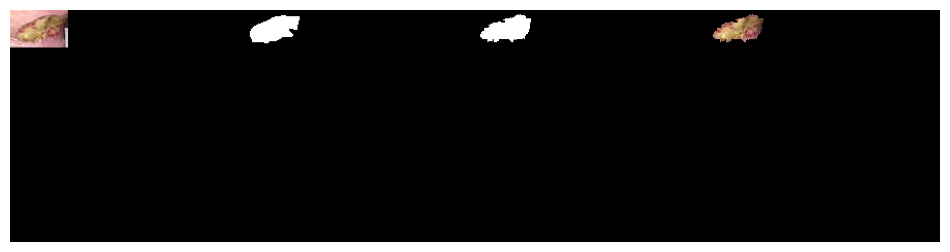

 Epoch: 51 of 100, Iter.: 70 of 70, Train Loss: 0.269522, IoU: 0.838634, Dice: 0.954393
 Epoch: 51 of 100, Iter.: 70 of 70, Valid Loss: 0.336696, IoU: 0.696807, Dice: 0.792823


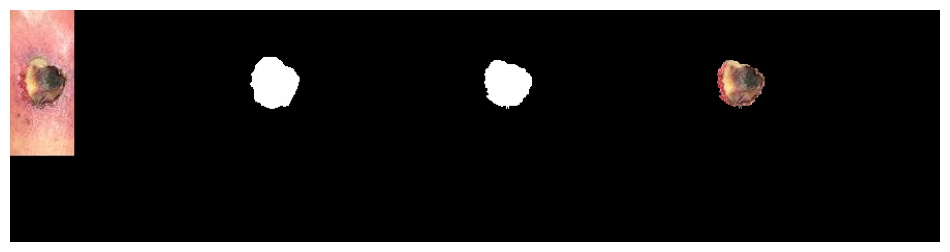

 Epoch: 52 of 100, Iter.: 70 of 70, Train Loss: 0.260396, IoU: 0.855086, Dice: 0.970077
 Epoch: 52 of 100, Iter.: 70 of 70, Valid Loss: 0.374410, IoU: 0.683113, Dice: 0.799712


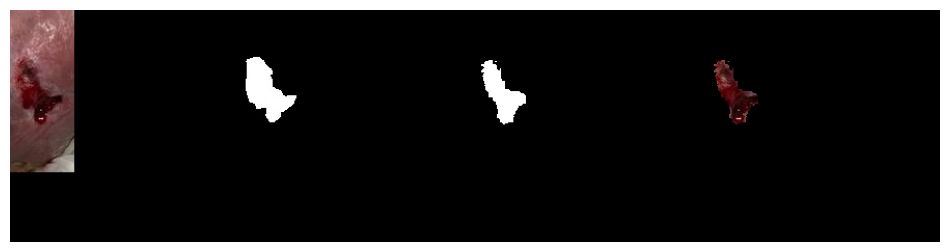

 Epoch: 53 of 100, Iter.: 70 of 70, Train Loss: 0.263360, IoU: 0.848014, Dice: 0.962349
 Epoch: 53 of 100, Iter.: 70 of 70, Valid Loss: 0.402813, IoU: 0.673207, Dice: 0.791887


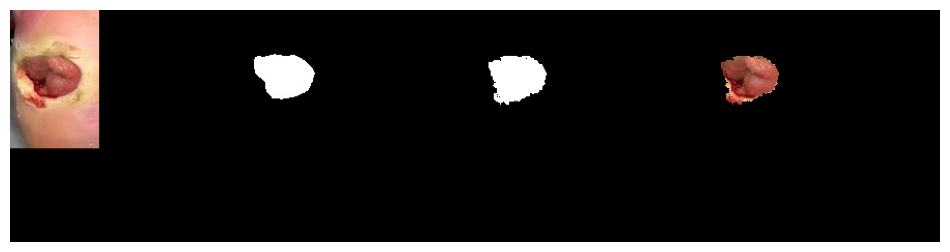

 Epoch: 54 of 100, Iter.: 70 of 70, Train Loss: 0.290338, IoU: 0.799972, Dice: 0.914462
 Epoch: 54 of 100, Iter.: 70 of 70, Valid Loss: 0.343589, IoU: 0.705818, Dice: 0.819154


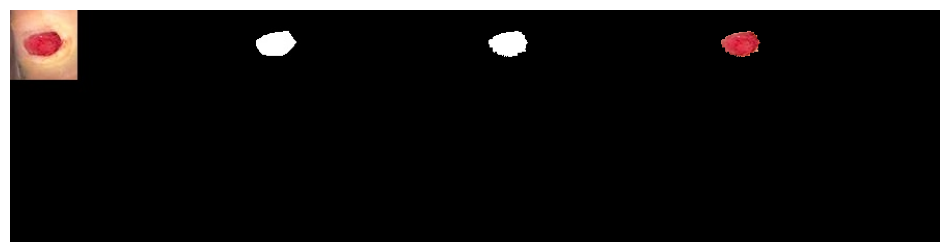

 Epoch: 55 of 100, Iter.: 70 of 70, Train Loss: 0.275357, IoU: 0.824870, Dice: 0.944316
 Epoch: 55 of 100, Iter.: 70 of 70, Valid Loss: 0.389528, IoU: 0.662447, Dice: 0.778695


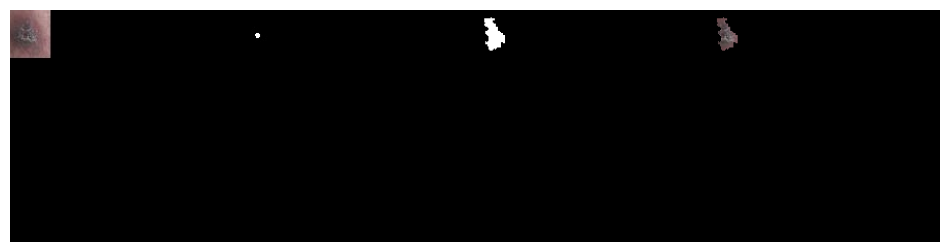

 Epoch: 56 of 100, Iter.: 70 of 70, Train Loss: 0.305366, IoU: 0.752187, Dice: 0.879665
 Epoch: 56 of 100, Iter.: 70 of 70, Valid Loss: 0.395320, IoU: 0.645267, Dice: 0.765842


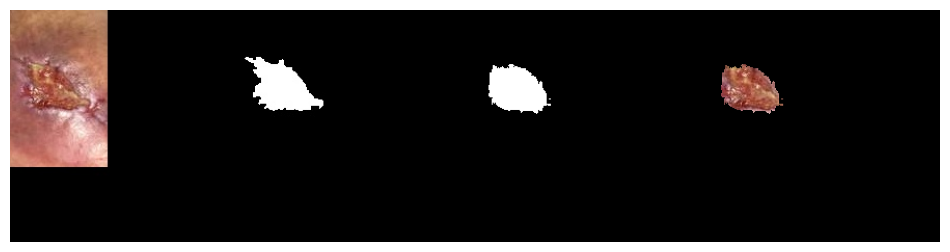

 Epoch: 57 of 100, Iter.: 70 of 70, Train Loss: 0.312082, IoU: 0.773374, Dice: 0.894377
 Epoch: 57 of 100, Iter.: 70 of 70, Valid Loss: 0.353372, IoU: 0.675951, Dice: 0.795223


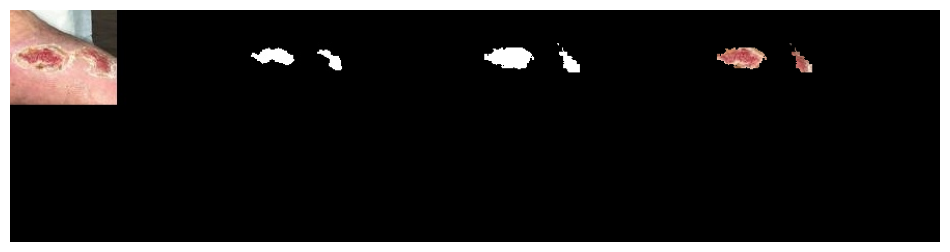

 Epoch: 58 of 100, Iter.: 70 of 70, Train Loss: 0.277178, IoU: 0.820630, Dice: 0.937561
 Epoch: 58 of 100, Iter.: 70 of 70, Valid Loss: 0.350573, IoU: 0.709208, Dice: 0.828260


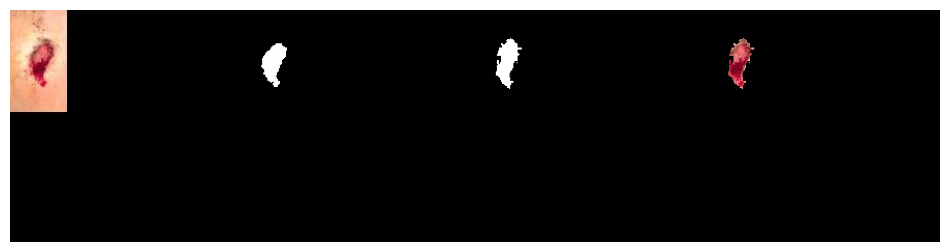

 Epoch: 59 of 100, Iter.: 70 of 70, Train Loss: 0.253756, IoU: 0.856841, Dice: 0.970701
 Epoch: 59 of 100, Iter.: 70 of 70, Valid Loss: 0.337214, IoU: 0.718425, Dice: 0.828622


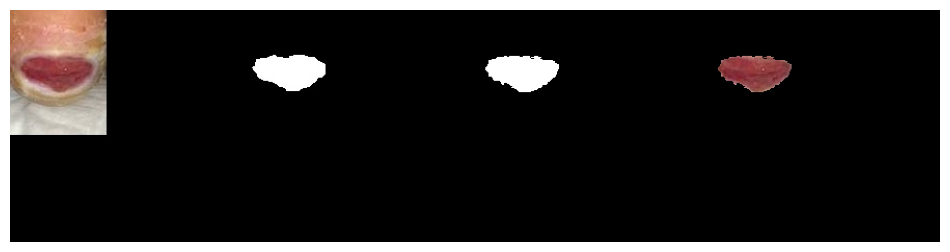

 Epoch: 60 of 100, Iter.: 70 of 70, Train Loss: 0.253723, IoU: 0.858109, Dice: 0.971252
 Epoch: 60 of 100, Iter.: 70 of 70, Valid Loss: 0.336833, IoU: 0.722198, Dice: 0.834551


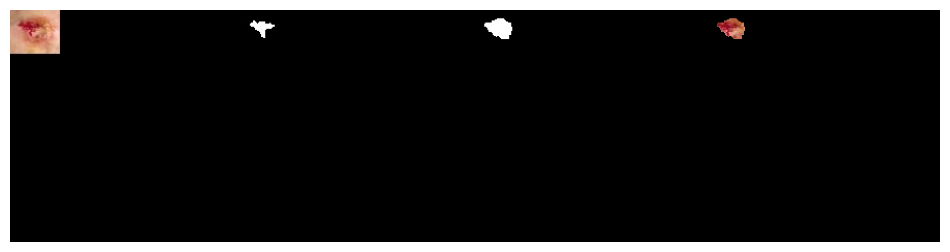

 Epoch: 61 of 100, Iter.: 70 of 70, Train Loss: 0.255034, IoU: 0.854033, Dice: 0.965667
 Epoch: 61 of 100, Iter.: 70 of 70, Valid Loss: 0.334550, IoU: 0.710605, Dice: 0.824618


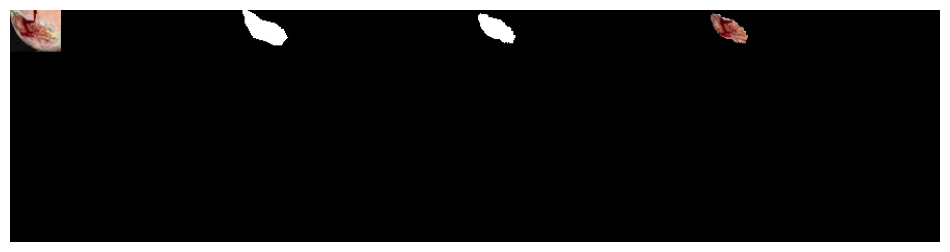

 Epoch: 62 of 100, Iter.: 70 of 70, Train Loss: 0.267519, IoU: 0.845162, Dice: 0.961474
 Epoch: 62 of 100, Iter.: 70 of 70, Valid Loss: 0.336489, IoU: 0.716398, Dice: 0.828591


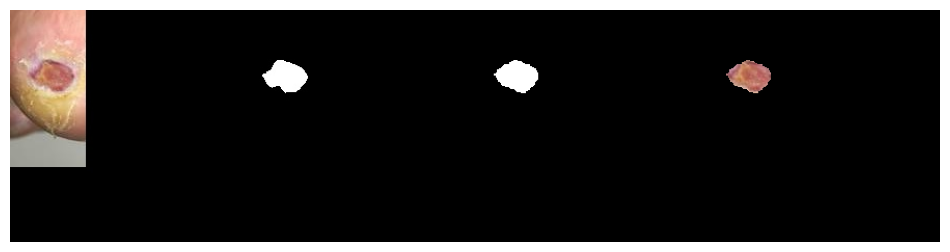

 Epoch: 63 of 100, Iter.: 70 of 70, Train Loss: 0.258275, IoU: 0.861704, Dice: 0.972932
 Epoch: 63 of 100, Iter.: 70 of 70, Valid Loss: 0.329995, IoU: 0.721556, Dice: 0.836283


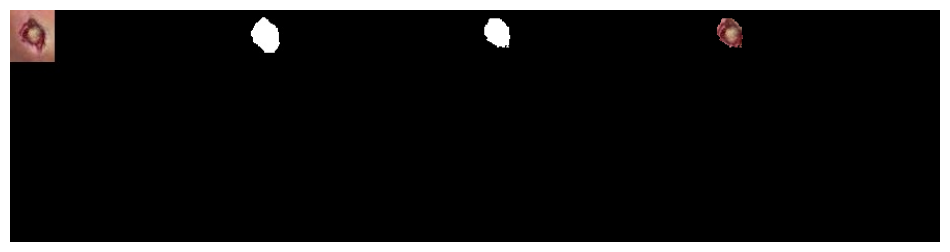

 Epoch: 64 of 100, Iter.: 70 of 70, Train Loss: 0.249897, IoU: 0.867901, Dice: 0.979914
 Epoch: 64 of 100, Iter.: 70 of 70, Valid Loss: 0.339725, IoU: 0.716996, Dice: 0.831807


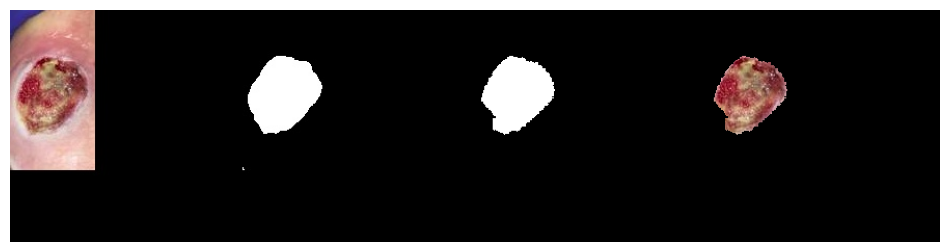

 Epoch: 65 of 100, Iter.: 70 of 70, Train Loss: 0.245520, IoU: 0.877654, Dice: 0.991037
 Epoch: 65 of 100, Iter.: 70 of 70, Valid Loss: 0.336792, IoU: 0.718780, Dice: 0.831324


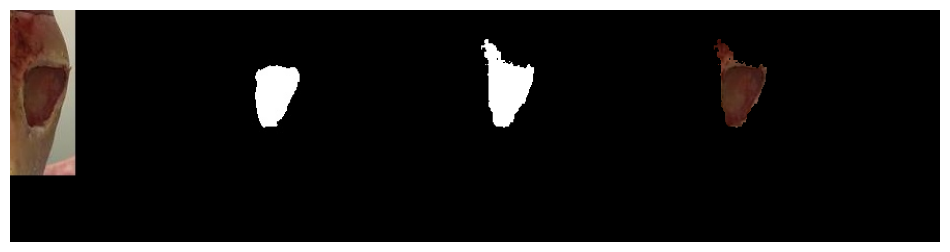

 Epoch: 66 of 100, Iter.: 70 of 70, Train Loss: 0.240378, IoU: 0.879159, Dice: 0.986146
 Epoch: 66 of 100, Iter.: 70 of 70, Valid Loss: 0.339719, IoU: 0.719658, Dice: 0.833395


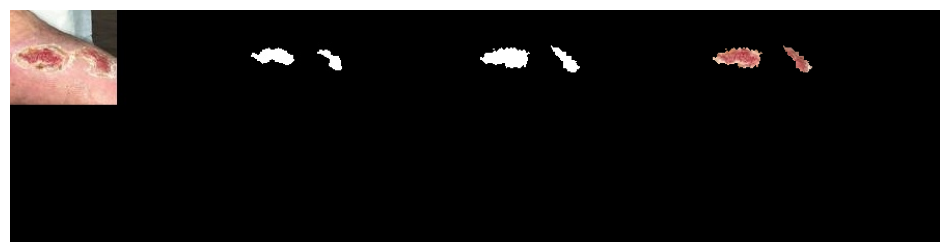

 Epoch: 67 of 100, Iter.: 70 of 70, Train Loss: 0.238208, IoU: 0.886742, Dice: 0.996436
 Epoch: 67 of 100, Iter.: 70 of 70, Valid Loss: 0.345298, IoU: 0.715613, Dice: 0.830435


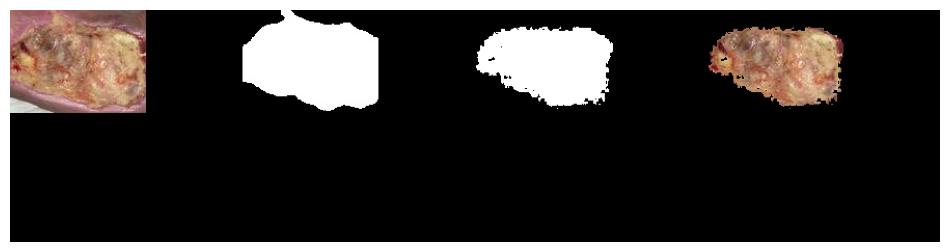

 Epoch: 68 of 100, Iter.: 70 of 70, Train Loss: 0.239235, IoU: 0.882861, Dice: 0.994125
 Epoch: 68 of 100, Iter.: 70 of 70, Valid Loss: 0.334837, IoU: 0.719639, Dice: 0.831605


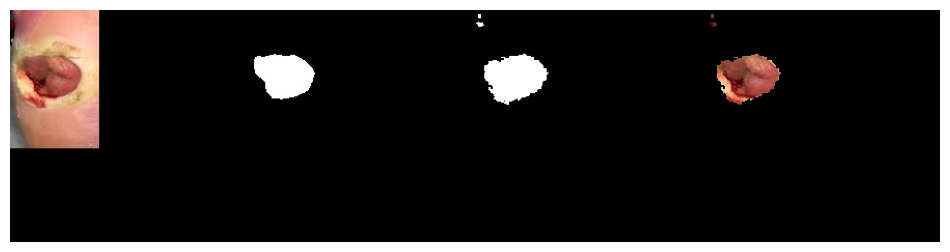

 Epoch: 69 of 100, Iter.: 70 of 70, Train Loss: 0.244851, IoU: 0.883158, Dice: 0.991675
 Epoch: 69 of 100, Iter.: 70 of 70, Valid Loss: 0.333761, IoU: 0.720213, Dice: 0.832644


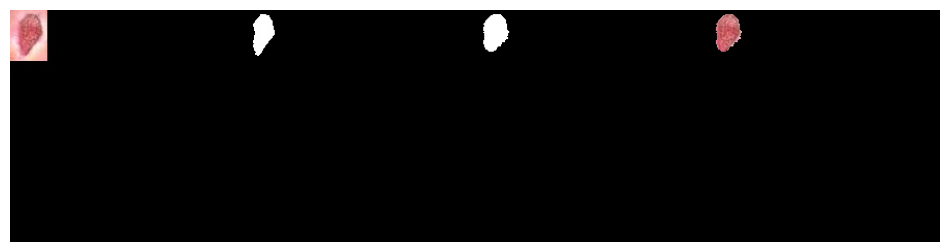

 Epoch: 70 of 100, Iter.: 70 of 70, Train Loss: 0.239389, IoU: 0.885966, Dice: 0.996183
 Epoch: 70 of 100, Iter.: 70 of 70, Valid Loss: 0.333021, IoU: 0.717826, Dice: 0.827254


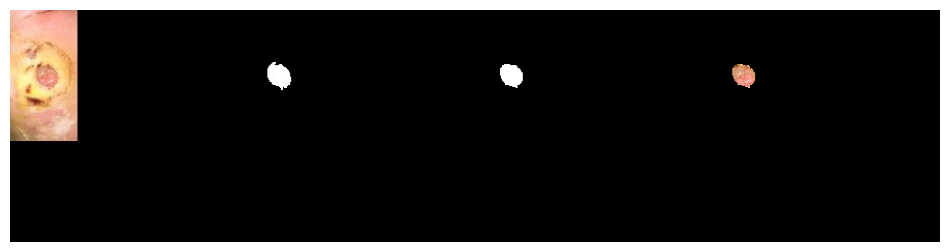

 Epoch: 71 of 100, Iter.: 70 of 70, Train Loss: 0.241903, IoU: 0.886605, Dice: 0.996789
 Epoch: 71 of 100, Iter.: 70 of 70, Valid Loss: 0.338826, IoU: 0.720931, Dice: 0.838363


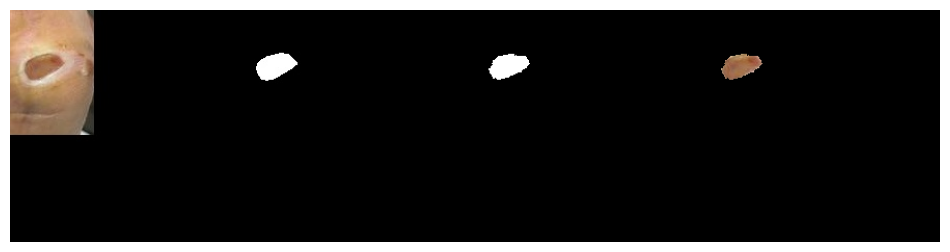

 Epoch: 72 of 100, Iter.: 70 of 70, Train Loss: 0.237559, IoU: 0.889232, Dice: 0.997945
 Epoch: 72 of 100, Iter.: 70 of 70, Valid Loss: 0.329387, IoU: 0.722753, Dice: 0.832887


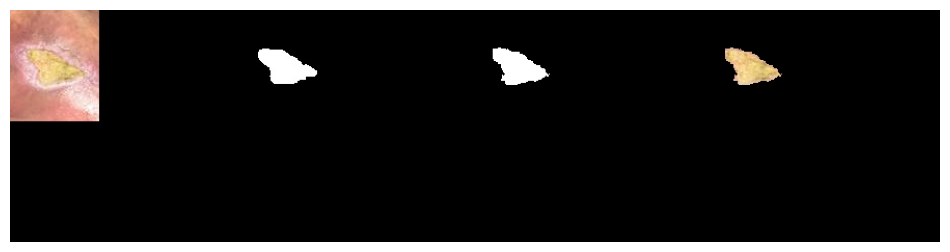

 Epoch: 73 of 100, Iter.: 70 of 70, Train Loss: 0.235720, IoU: 0.889280, Dice: 0.998085
 Epoch: 73 of 100, Iter.: 70 of 70, Valid Loss: 0.330239, IoU: 0.720556, Dice: 0.831169


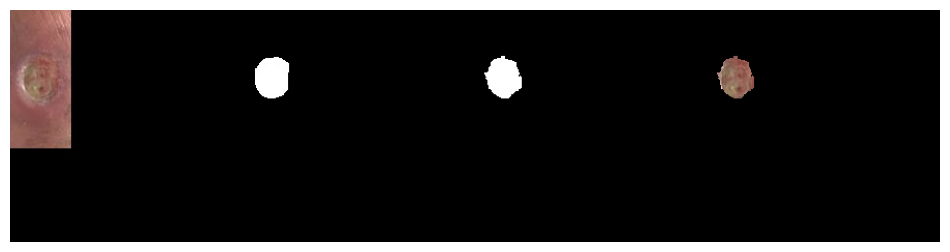

 Epoch: 74 of 100, Iter.: 70 of 70, Train Loss: 0.229573, IoU: 0.892336, Dice: 0.999862
 Epoch: 74 of 100, Iter.: 70 of 70, Valid Loss: 0.331509, IoU: 0.721194, Dice: 0.828843


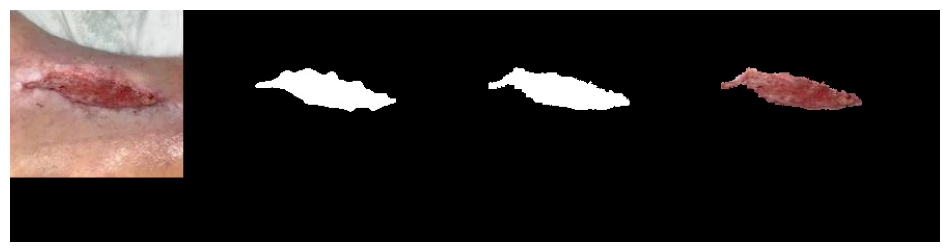

 Epoch: 75 of 100, Iter.: 70 of 70, Train Loss: 0.233704, IoU: 0.892506, Dice: 1.000255
 Epoch: 75 of 100, Iter.: 70 of 70, Valid Loss: 0.324201, IoU: 0.725824, Dice: 0.828062


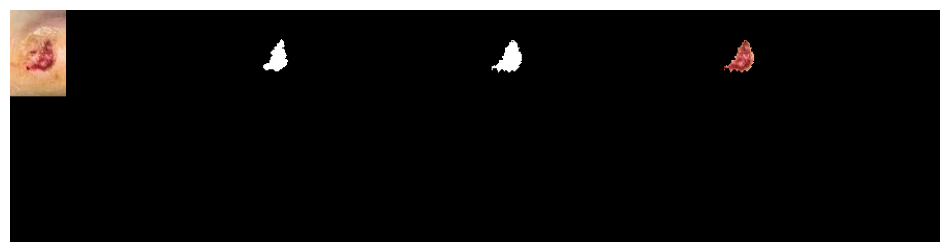

 Epoch: 76 of 100, Iter.: 70 of 70, Train Loss: 0.240563, IoU: 0.880755, Dice: 0.985579
 Epoch: 76 of 100, Iter.: 70 of 70, Valid Loss: 0.323364, IoU: 0.726008, Dice: 0.830965


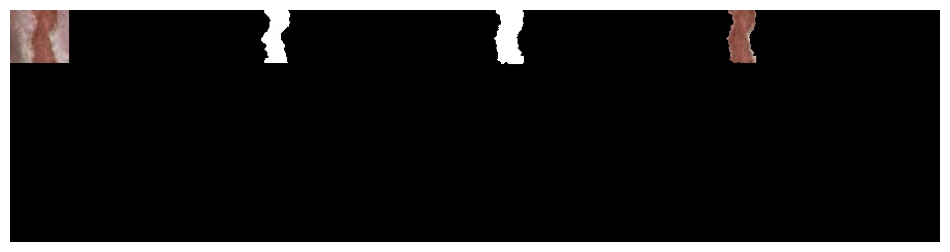

 Epoch: 77 of 100, Iter.: 70 of 70, Train Loss: 0.229246, IoU: 0.884954, Dice: 0.980516
 Epoch: 77 of 100, Iter.: 70 of 70, Valid Loss: 0.328725, IoU: 0.720746, Dice: 0.833058


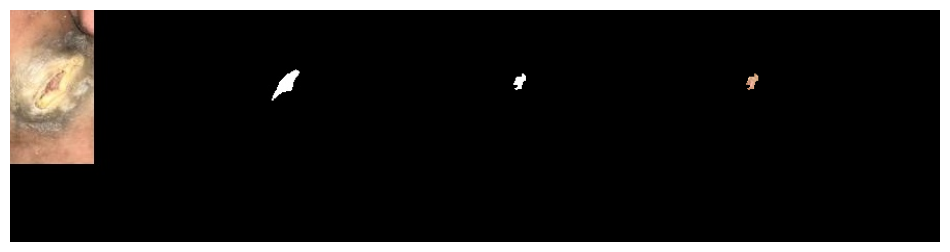

 Epoch: 78 of 100, Iter.: 70 of 70, Train Loss: 0.232399, IoU: 0.885033, Dice: 0.992857
 Epoch: 78 of 100, Iter.: 70 of 70, Valid Loss: 0.327521, IoU: 0.722860, Dice: 0.832143


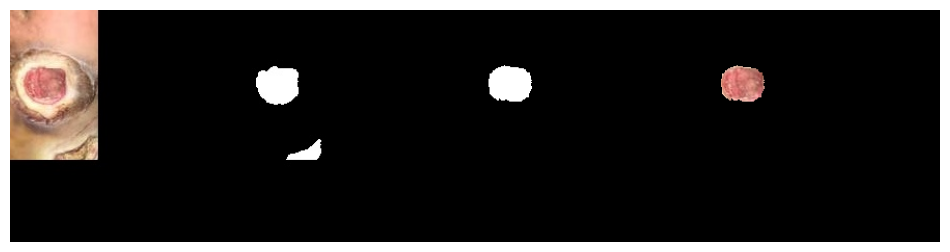

 Epoch: 79 of 100, Iter.: 70 of 70, Train Loss: 0.222648, IoU: 0.890063, Dice: 0.993581
 Epoch: 79 of 100, Iter.: 70 of 70, Valid Loss: 0.331192, IoU: 0.713045, Dice: 0.823940


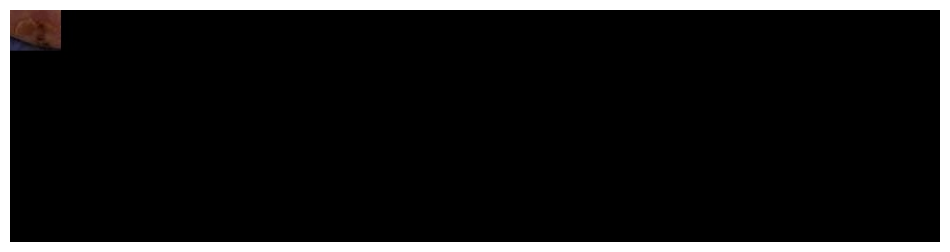

 Epoch: 80 of 100, Iter.: 70 of 70, Train Loss: 0.232275, IoU: 0.888350, Dice: 0.997709
 Epoch: 80 of 100, Iter.: 70 of 70, Valid Loss: 0.330359, IoU: 0.714309, Dice: 0.826786


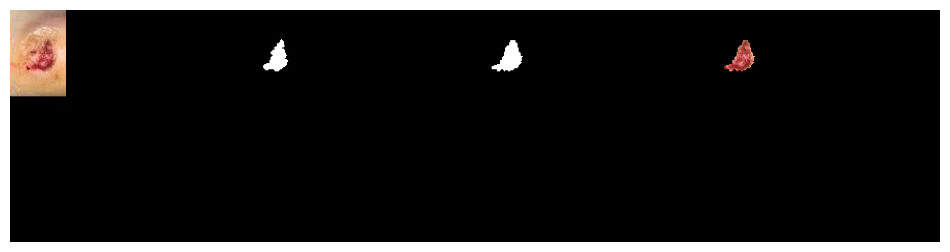

 Epoch: 81 of 100, Iter.: 70 of 70, Train Loss: 0.238417, IoU: 0.883145, Dice: 0.990629
 Epoch: 81 of 100, Iter.: 70 of 70, Valid Loss: 0.319186, IoU: 0.725583, Dice: 0.831168


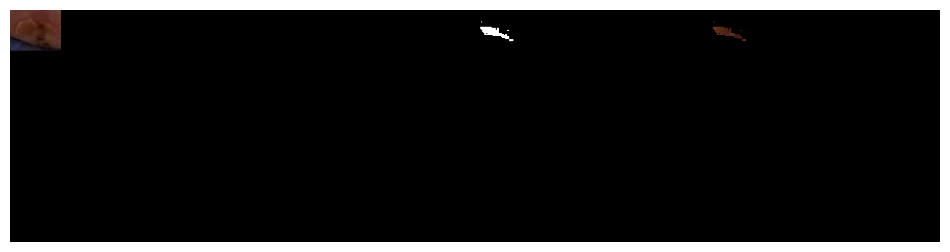

 Epoch: 82 of 100, Iter.: 70 of 70, Train Loss: 0.232600, IoU: 0.886575, Dice: 0.993757
 Epoch: 82 of 100, Iter.: 70 of 70, Valid Loss: 0.338607, IoU: 0.719437, Dice: 0.831493


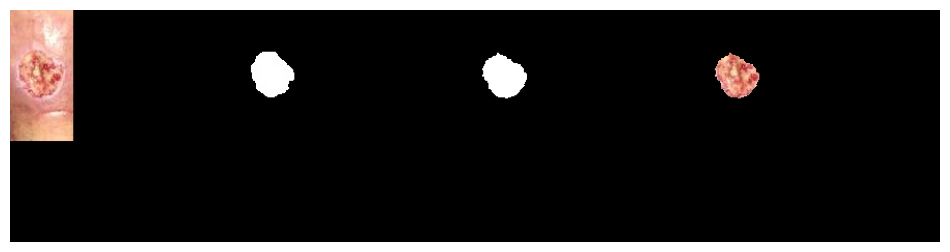

 Epoch: 83 of 100, Iter.: 70 of 70, Train Loss: 0.230324, IoU: 0.884470, Dice: 0.991747
 Epoch: 83 of 100, Iter.: 70 of 70, Valid Loss: 0.332843, IoU: 0.717702, Dice: 0.825853


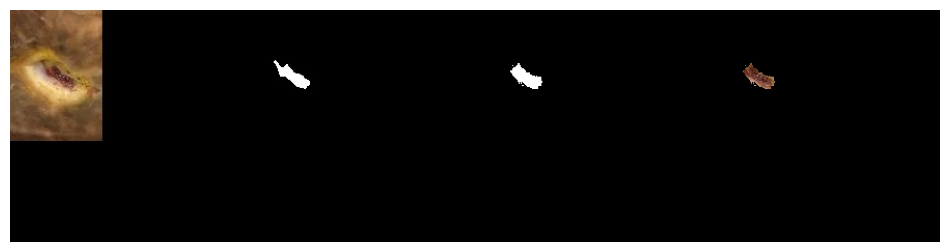

 Epoch: 84 of 100, Iter.: 70 of 70, Train Loss: 0.221786, IoU: 0.888815, Dice: 0.997315
 Epoch: 84 of 100, Iter.: 70 of 70, Valid Loss: 0.333053, IoU: 0.721750, Dice: 0.837629


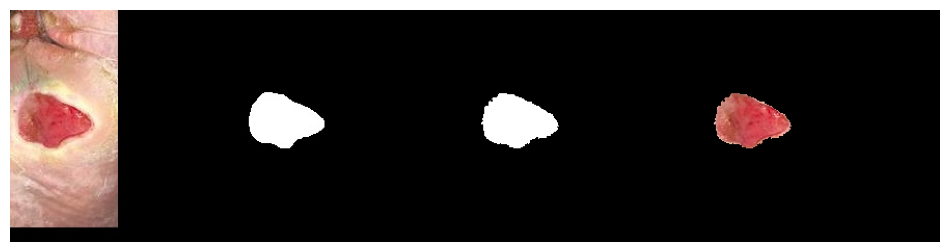

 Epoch: 85 of 100, Iter.: 70 of 70, Train Loss: 0.223202, IoU: 0.893703, Dice: 0.995772
 Epoch: 85 of 100, Iter.: 70 of 70, Valid Loss: 0.322571, IoU: 0.719054, Dice: 0.827766


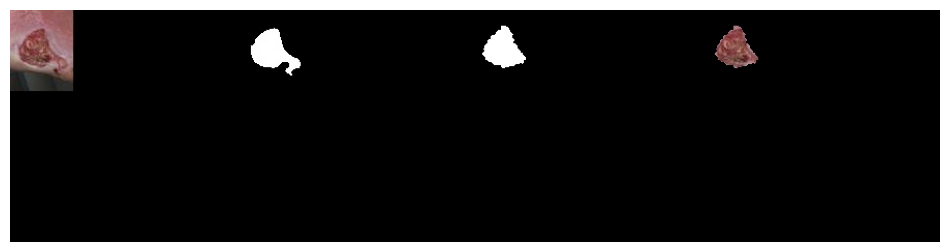

 Epoch: 86 of 100, Iter.: 70 of 70, Train Loss: 0.217003, IoU: 0.898885, Dice: 1.003760
 Epoch: 86 of 100, Iter.: 70 of 70, Valid Loss: 0.338393, IoU: 0.716043, Dice: 0.828274


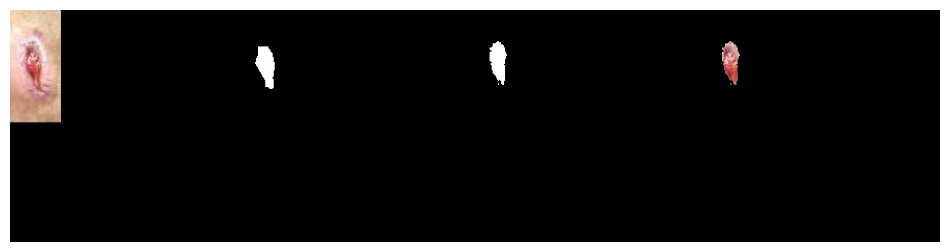

 Epoch: 87 of 100, Iter.: 70 of 70, Train Loss: 0.224029, IoU: 0.894946, Dice: 1.001245
 Epoch: 87 of 100, Iter.: 70 of 70, Valid Loss: 0.330151, IoU: 0.722443, Dice: 0.832356


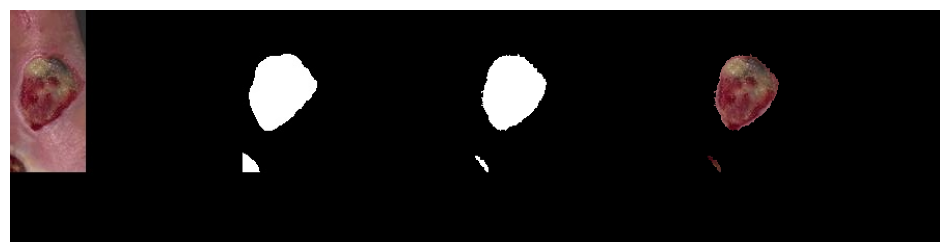

 Epoch: 88 of 100, Iter.: 70 of 70, Train Loss: 0.222427, IoU: 0.890489, Dice: 0.996237
 Epoch: 88 of 100, Iter.: 70 of 70, Valid Loss: 0.336177, IoU: 0.714929, Dice: 0.831028


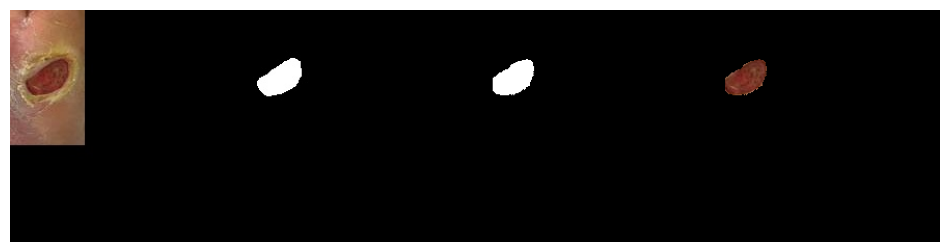

 Epoch: 89 of 100, Iter.: 70 of 70, Train Loss: 0.221840, IoU: 0.896045, Dice: 1.002089
 Epoch: 89 of 100, Iter.: 70 of 70, Valid Loss: 0.314454, IoU: 0.728107, Dice: 0.832144


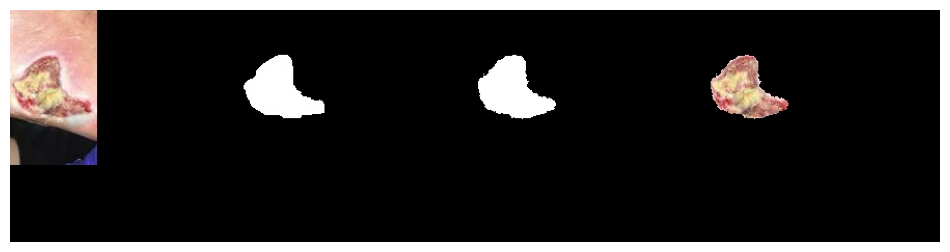

 Epoch: 90 of 100, Iter.: 70 of 70, Train Loss: 0.224586, IoU: 0.897319, Dice: 1.002889
 Epoch: 90 of 100, Iter.: 70 of 70, Valid Loss: 0.315269, IoU: 0.727833, Dice: 0.831998


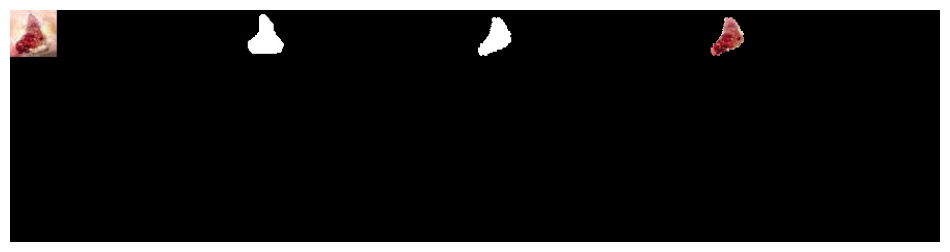

 Epoch: 91 of 100, Iter.: 70 of 70, Train Loss: 0.215848, IoU: 0.891480, Dice: 0.996734
 Epoch: 91 of 100, Iter.: 70 of 70, Valid Loss: 0.325070, IoU: 0.718570, Dice: 0.827710


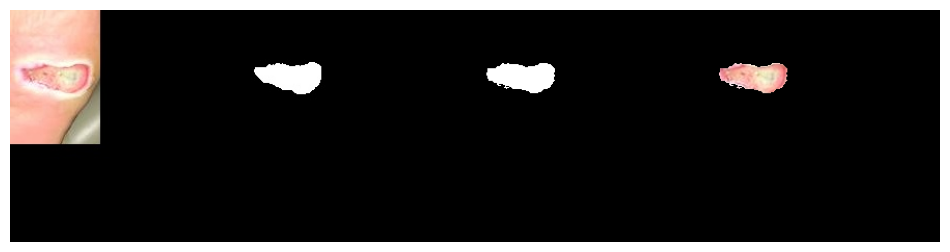

 Epoch: 92 of 100, Iter.: 70 of 70, Train Loss: 0.221654, IoU: 0.893339, Dice: 1.000282
 Epoch: 92 of 100, Iter.: 70 of 70, Valid Loss: 0.323810, IoU: 0.725823, Dice: 0.835676


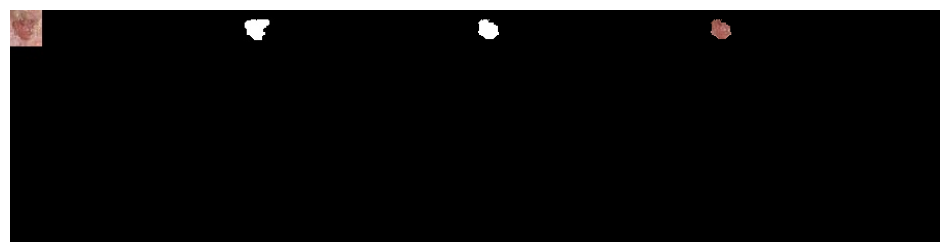


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 19min 50s, sys: 5min 36s, total: 25min 27s
Wall time: 19min 43s


In [19]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:71, Best_IOU:0.7281, Best_DiceScore:0.8384


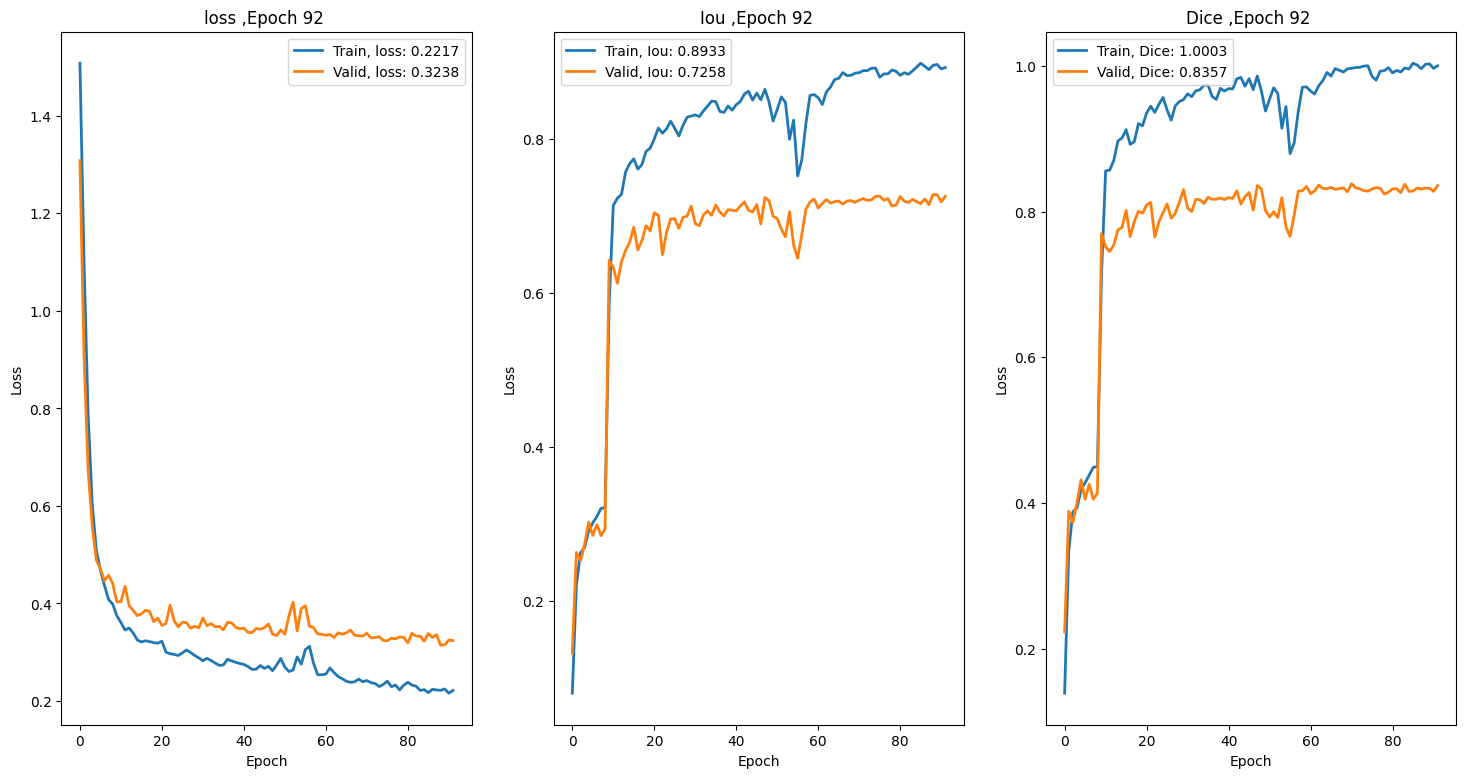

In [20]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()